# Epilepsy Detection with LSTMs — Inference & Evaluation
*Generated: 2025-09-04 06:17:31*

This notebook loads the saved scaler and model, reproduces the preprocessing,
and evaluates predictions on both the **validation** and **training** sets
(so you can compare performance and check for overfitting).

## 0. Setup

In [29]:
# !pip install numpy pandas scikit-learn matplotlib tensorflow==2.* joblib

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score
import joblib
import tensorflow as tf

from tensorflow.keras.models import load_model

DATA_PATH = "new_eeg_normal.csv"
MODEL_DIR = "./models"
MODEL_PATH = os.path.join(MODEL_DIR, "epilepsy_lstm2.keras")
SCALER_PATH = os.path.join(MODEL_DIR, "scaler2.joblib")

assert os.path.exists(MODEL_PATH), f"Model not found at {MODEL_PATH}. Train it first in Model.ipynb."
# assert os.path.exists(SCALER_PATH), f"Scaler not found at {SCALER_PATH}. Train it first in Model.ipynb."

model = load_model(MODEL_PATH)
scaler = joblib.load(SCALER_PATH)
print("Loaded model and scaler.")

Loaded model and scaler.


## 1. Load & prepare data (same steps as training)

In [30]:
df = pd.read_csv("new_eeg_normal.csv")
for col in list(df.columns):
    if 'unnamed' in col.lower():
        df = df.drop(columns=[col])

label_col = 'y' if 'y' in df.columns else df.columns[-1]
X = df.drop(columns=[label_col]).values
y_raw = df[label_col].values
y = (y_raw == 1).astype(int)

# Use the same random_state and split proportions as training for consistent val set
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train_s = scaler.transform(X_train)
X_val_s   = scaler.transform(X_val)

def to_sequences(arr_2d):
    return arr_2d.reshape(arr_2d.shape[0], arr_2d.shape[1], 1)

X_train_seq = to_sequences(X_train_s)
X_val_seq   = to_sequences(X_val_s)

print("Shapes — X_train_seq:", X_train_seq.shape, "X_val_seq:", X_val_seq.shape)

ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

## 2. Predict on validation & training sets

In [31]:
val_prob = model.predict(X_val_seq).ravel()
val_pred = (val_prob >= 0.5).astype(int)

tr_prob = model.predict(X_train_seq).ravel()
tr_pred = (tr_prob >= 0.5).astype(int)

print("Val AUC:", round(roc_auc_score(y_val, val_prob), 4))
print("Train AUC:", round(roc_auc_score(y_train, tr_prob), 4))

print("\nValidation report:")
print(classification_report(y_val, val_pred, digits=4))

print("\nTraining report:")
print(classification_report(y_train, tr_pred, digits=4))

72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step
288/288 ━━━━━━━━━━━━━━━━━━━━ 21s 72ms/step
Val AUC: 0.9881
Train AUC: 0.9909

Validation report:
              precision    recall  f1-score   support

           0     0.9777    0.9750    0.9763      1840
           1     0.9011    0.9109    0.9059       460

    accuracy                         0.9622      2300
   macro avg     0.9394    0.9429    0.9411      2300
weighted avg     0.9623    0.9622    0.9623      2300


Training report:
              precision    recall  f1-score   support

           0     0.9804    0.9780    0.9792      7360
           1     0.9128    0.9217    0.9173      1840

    accuracy                         0.9667      9200
   macro avg     0.9466    0.9499    0.9482      9200
weighted avg     0.9669    0.9667    0.9668      9200



## 3. Confusion matrices

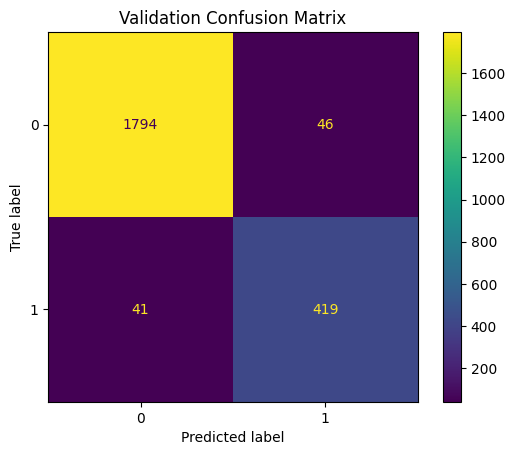

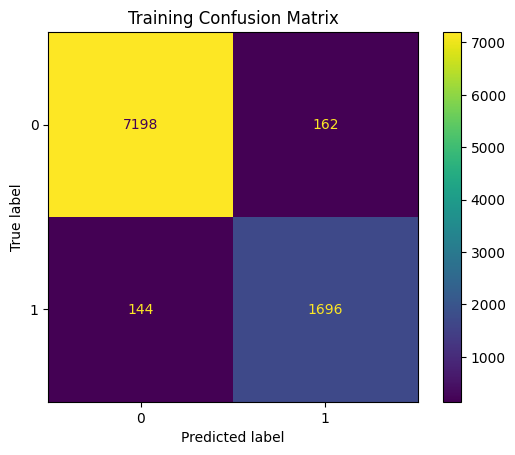

In [32]:
cm_val = confusion_matrix(y_val, val_pred)
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val)
disp_val.plot()
plt.title("Validation Confusion Matrix")
plt.show()

cm_tr = confusion_matrix(y_train, tr_pred)
disp_tr = ConfusionMatrixDisplay(confusion_matrix=cm_tr)
disp_tr.plot()
plt.title("Training Confusion Matrix")
plt.show()

## 4. Export predictions (optional)

In [33]:
out_val = pd.DataFrame({
    "y_true": y_val,
    "y_prob": val_prob,
    "y_pred": val_pred
})
out_tr = pd.DataFrame({
    "y_true": y_train,
    "y_prob": tr_prob,
    "y_pred": tr_pred
})

val_csv = "/mnt/data/val_predictions2.csv"
tr_csv  = "/mnt/data/train_predictions2.csv"

out_val.to_csv(val_csv, index=False)
out_tr.to_csv(tr_csv, index=False)

print("Saved:", val_csv)
print("Saved:", tr_csv)

Saved: /mnt/data/val_predictions2.csv
Saved: /mnt/data/train_predictions2.csv


## 5. Predict on a single new sample (example)

In [11]:
## pick one sample from the validation set
sample = X_val[0].reshape(1, -1)  

# apply the same StandardScaler used during training
sample_s = scaler.transform(sample)  

# reshape into (batch, timesteps, features) = (1, 178, 1) for the LSTM
sample_seq = sample_s.reshape(1, sample_s.shape[1], 1)  

# predict probability from the model
prob = model.predict(sample_seq).item()  

# convert probability into binary label (>=0.5 => 1, else 0)
pred = int(prob >= 0.5)  

print(f"Pred prob: {prob:.4f} -> Pred label: {pred}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
Pred prob: 0.5460 -> Pred label: 1


In [34]:
import numpy as np
import joblib
from tensorflow import keras

# === Load Model and Scaler ===
MODEL_PATH = "./models/epilepsy_lstm2.keras"
SCALER_PATH = "./models/scaler2.joblib"

model = keras.models.load_model(MODEL_PATH)
scaler = joblib.load(SCALER_PATH)

print("Model and scaler loaded successfully.")

# === Function to Predict on New EEG Sample ===
def predict_new_eeg(file_path, model, scaler):
    """
    Predict whether a new EEG sample (CSV file) is epileptic or not.
    file_path: path to CSV file containing 178 values in a single row
    """
    # Load EEG data
    new_sample = np.loadtxt(file_path, delimiter=",")
    
    # Ensure shape is correct
    new_sample = new_sample.reshape(1, -1)
    
    # Scale
    new_sample_s = scaler.transform(new_sample)
    
    # Reshape for LSTM (batch, timesteps, features)
    new_sample_seq = new_sample_s.reshape(1, new_sample_s.shape[1], 1)
    
    # Predict
    prob = model.predict(new_sample_seq).item()
    pred = int(prob >= 0.5)
    
    print(f"Prediction Probability: {prob:.4f}")
    print("Result: Epileptic" if pred == 1 else "Result: Not Epileptic")
    return prob, pred


Model and scaler loaded successfully.


In [35]:
df = pd.read_csv("new_eeg_normal.csv", header=None)
print(df.shape)

(1, 178)


In [36]:
file_path = "new_eeg_normal.csv"
predict_new_eeg(file_path, model, scaler)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 878ms/step
Prediction Probability: 0.2731
Result: Not Epileptic


(0.273086279630661, 0)

In [27]:
# predict_new_eeg("./new_eeg_normal.csv", model, scaler)
# predict_new_eeg("./new_eeg_epileptic.csv", model, scaler)
import matplotlib.pyplot as plt

def plot_eeg(file_path, model, scaler):
    """
    Load an EEG CSV file, predict epileptic/not, and plot waveform.
    """
    # Load data
    signal = np.loadtxt(file_path, delimiter=",")
    
    # Prediction
    prob, pred = predict_new_eeg(file_path, model, scaler)
    
    # Plot
    plt.figure(figsize=(12,4))
    plt.plot(signal, color="blue", linewidth=1.2)
    plt.title(f"EEG Signal from {file_path}\nPrediction: {'Epileptic' if pred==1 else 'Not Epileptic'} "
              f"(prob={prob:.2f})", fontsize=14)
    plt.xlabel("Time steps")
    plt.ylabel("Amplitude")
    plt.grid(True, alpha=0.3)
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 804ms/step
Prediction Probability: 0.2731
Result: Not Epileptic


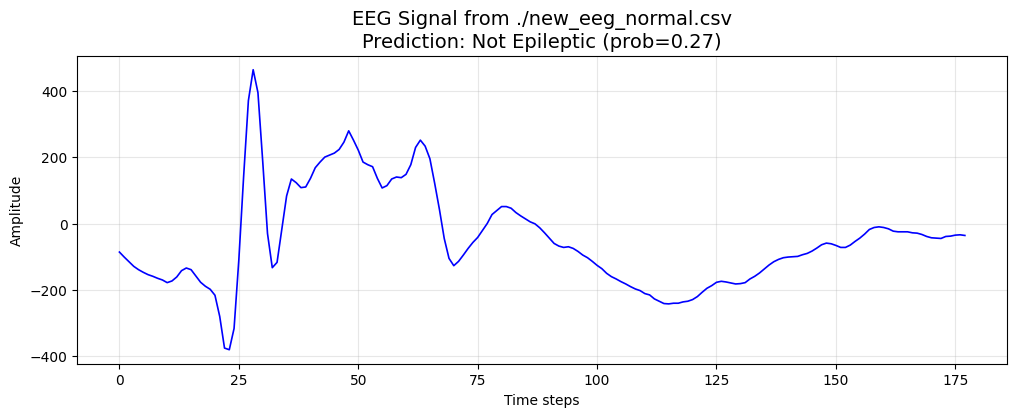

In [28]:
plot_eeg("./new_eeg_normal.csv", model, scaler)